# Bonus Certificates with Cap

**Author:** Thoran Tschöpe, Michael Ketterl, Theresa Richter, Leon Makaryan, Jawed Mohammadi
**Course:** Financial Mathematics 2  
**Professor:** Prof. Dr. Rudi Zagst  
**Institution:** Technical University of Munich, Department of Mathematics

This notebook presents a comprehensive analysis of Bonus Certificates with Cap.

## Table of Contents

1. [Data Analysis and Exploration](#1-data-analysis-and-exploration)
2. [Black-Scholes Model Calibration](#2-black-scholes-model-calibration)
3. [Understanding Bonus Certificates with Cap](#3-understanding-bonus-certificates-with-cap)
4. [Replication Strategy](#4-replication-strategy)
5. [Analytical Pricing](#5-analytical-pricing)
6. [Monte Carlo Simulation](#6-monte-carlo-simulation)
7. [Risk Analysis](#7-risk-analysis)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import norm
from numba import jit, prange
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### 1. Data Analysis and Exploration

In [2]:
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    df = df.dropna()
    
    return df

def plot_stock_evolution(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.plot(df.index, df['Close'], linewidth=2, color='darkblue')
    ax1.set_title('Deutsche Telekom Stock Price Evolution', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Price (EUR)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')
    
    ax2.plot(df.index, df['Log_Returns'], linewidth=0.5, color='darkgreen', alpha=0.8)
    ax2.set_title('Log Returns of Deutsche Telekom Stock', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Log Returns', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def calculate_statistics(df):
    log_returns = df['Log_Returns']
    
    statistics = {
        'Mean': log_returns.mean(),
        'Standard Deviation': log_returns.std(),
        'Minimum': log_returns.min(),
        'Maximum': log_returns.max(),
        'Skewness': stats.skew(log_returns),
        'Kurtosis': stats.kurtosis(log_returns),
        'Q1 (25th percentile)': log_returns.quantile(0.25),
        'Q2 (Median)': log_returns.quantile(0.50),
        'Q3 (75th percentile)': log_returns.quantile(0.75),
        'Annualized Mean': log_returns.mean() * 252,
        'Annualized Volatility': log_returns.std() * np.sqrt(252),
        'Sharpe Ratio (rf=2%)': (log_returns.mean() * 252 - 0.02) / (log_returns.std() * np.sqrt(252))
    }
    
    stats_df = pd.DataFrame(list(statistics.items()), 
                           columns=['Statistic', 'Value'])
    
    print("=" * 50)
    print("LOG RETURNS STATISTICS")
    print("=" * 50)
    print(stats_df.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(log_returns, bins=50, density=True, alpha=0.7, 
                              color='skyblue', edgecolor='black')
    
    mu, sigma = log_returns.mean(), log_returns.std()
    x = np.linspace(log_returns.min(), log_returns.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
            label=f'Normal({mu:.4f}, {sigma:.4f})')
    
    ax.set_title('Distribution of Log Returns', fontsize=16, fontweight='bold')
    ax.set_xlabel('Log Returns', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return statistics

Data loaded: 2540 observations
Date range: 2014-06-18 00:00:00 to 2024-06-14 00:00:00


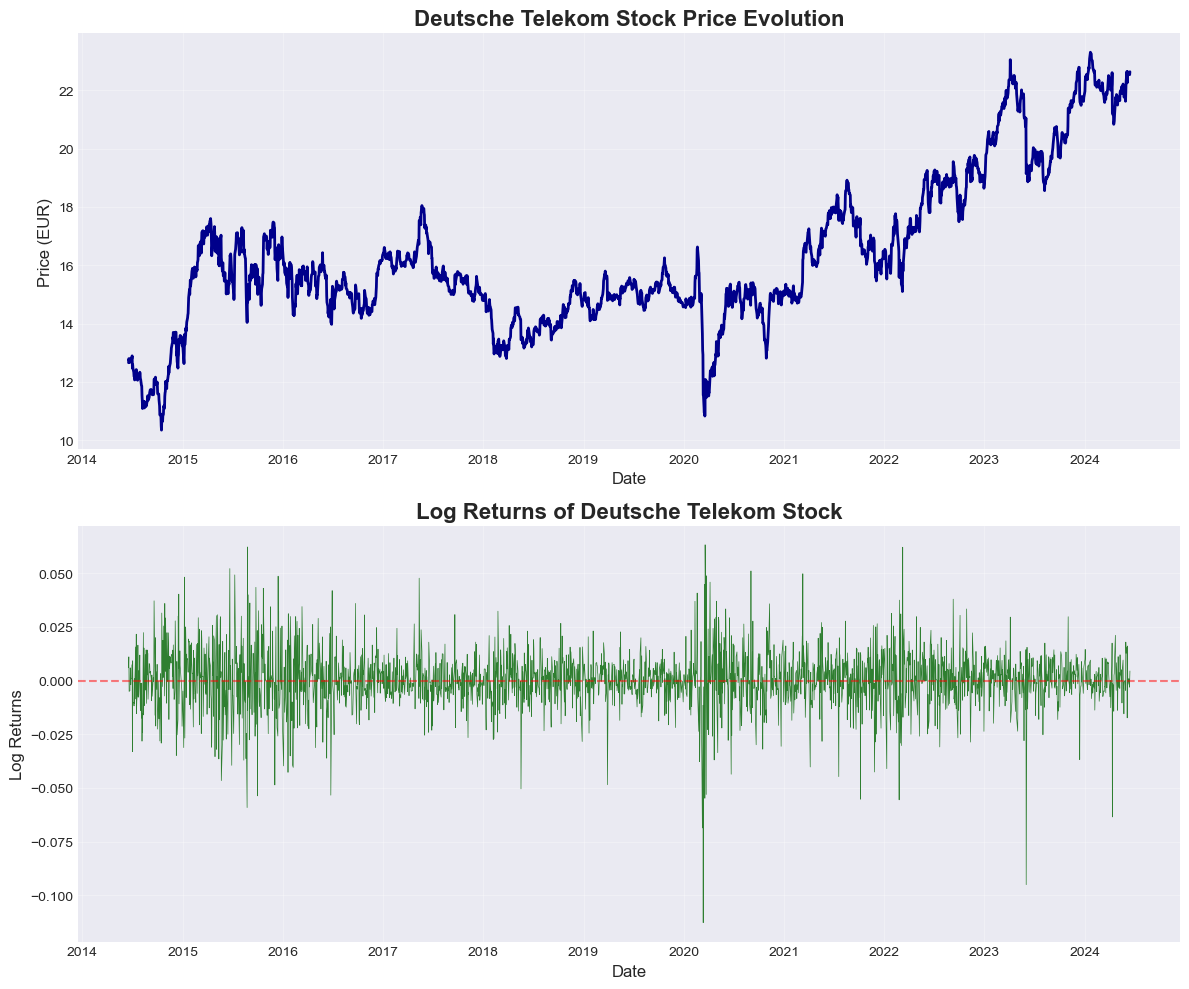

LOG RETURNS STATISTICS
            Statistic     Value
                 Mean  0.000231
   Standard Deviation  0.013379
              Minimum -0.112673
              Maximum  0.063141
             Skewness -0.464677
             Kurtosis  5.606269
 Q1 (25th percentile) -0.005909
          Q2 (Median)  0.000000
 Q3 (75th percentile)  0.007092
      Annualized Mean  0.058215
Annualized Volatility  0.212393
 Sharpe Ratio (rf=2%)  0.179926


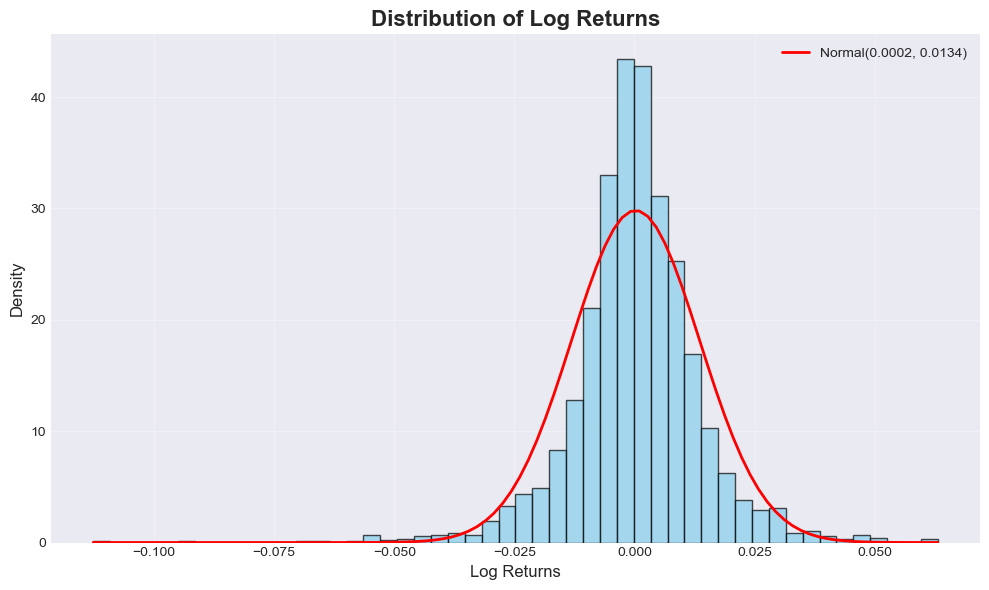

In [3]:
df = load_and_prepare_data('Telekom.csv')
print(f"Data loaded: {len(df)} observations")
print(f"Date range: {df.index[0]} to {df.index[-1]}")

plot_stock_evolution(df)

stats_dict = calculate_statistics(df)

### 2. Black-Scholes Model Calibration

In [4]:
def fit_black_scholes(log_returns, dt=1/252):
    sigma_hat = np.std(log_returns, ddof=1) / np.sqrt(dt)
    mu_hat = np.mean(log_returns) / dt + sigma_hat**2 / 2
    
    results = {
        'drift': mu_hat,
        'volatility': sigma_hat,
    }
    
    return results

In [5]:
print("Days in each year:")
df.index.year.value_counts().sort_index()

Days in each year:


Date
2014    136
2015    254
2016    255
2017    255
2018    252
2019    251
2020    254
2021    255
2022    257
2023    255
2024    116
Name: count, dtype: int64

In [6]:
bs_params = fit_black_scholes(df['Log_Returns'].values)

print(f"Estimated drift (mu): {bs_params['drift']:.4f}")
print(f"Estimated volatility (sigma): {bs_params['volatility']:.4f}")

Estimated drift (mu): 0.0808
Estimated volatility (sigma): 0.2124


### 3. Understanding Bonus Certificates with Cap

### Bonus Certificates with Cap – Comprehensive Overview

#### 1. Definition and Structure

A Bonus Certificate with Cap is a structured product that offers:

- Protection against moderate downside movements (down to the barrier level)
- A guaranteed bonus payment if the barrier is never breached
- Limited upside potential due to the cap

---

#### 2. Key Components

- **Initial Level** ($P_0$): Starting price of the underlying  
- **Barrier Level** ($H$): Protection threshold
- **Bonus Level** ($B$): Guaranteed payment if barrier is not breached  
- **Cap Level** ($C$): Maximum payout level  
- **Maturity** ($T$): Certificate expiration date  

---

#### 3. Payoff Profile

At maturity, the payoff depends on two conditions:

##### a) If the barrier is never touched during the life of the certificate:

$$
\text{Payoff} = \min\left( \max(P_T, B), C \right)
$$

##### b) If the barrier is touched at least once:

$$
\text{Payoff} = \min(P_T, C)
$$

---

#### 4. Investor Motivation

- **Protection:** Limited downside risk if the underlying doesn't fall too much  
- **Bonus:** Attractive return even in sideways markets  
- **Simplicity:** Clear and transparent payoff structure  
- **Yield Enhancement:** Better returns than bonds in moderate scenarios  

---

#### 5. Risks to Consider

- **Barrier Breach:** Loss of bonus and protection if barrier is touched  
- **Volatility:** High volatility in the underlying increases risk of barrier being touched, which voids bonus protection
- **Capped Upside:** Cannot benefit from strong rallies above the cap  
- **Credit Risk:** Issuer default risk (certificate is an unsecured bond)  
- **Path Dependency:** Payoff depends on the entire price path, not just the final value  
- **Opportunity Cost:** May underperform direct investment in bull markets  
- **Dividend Waiver:** No dividends from the underlying are passed to investors


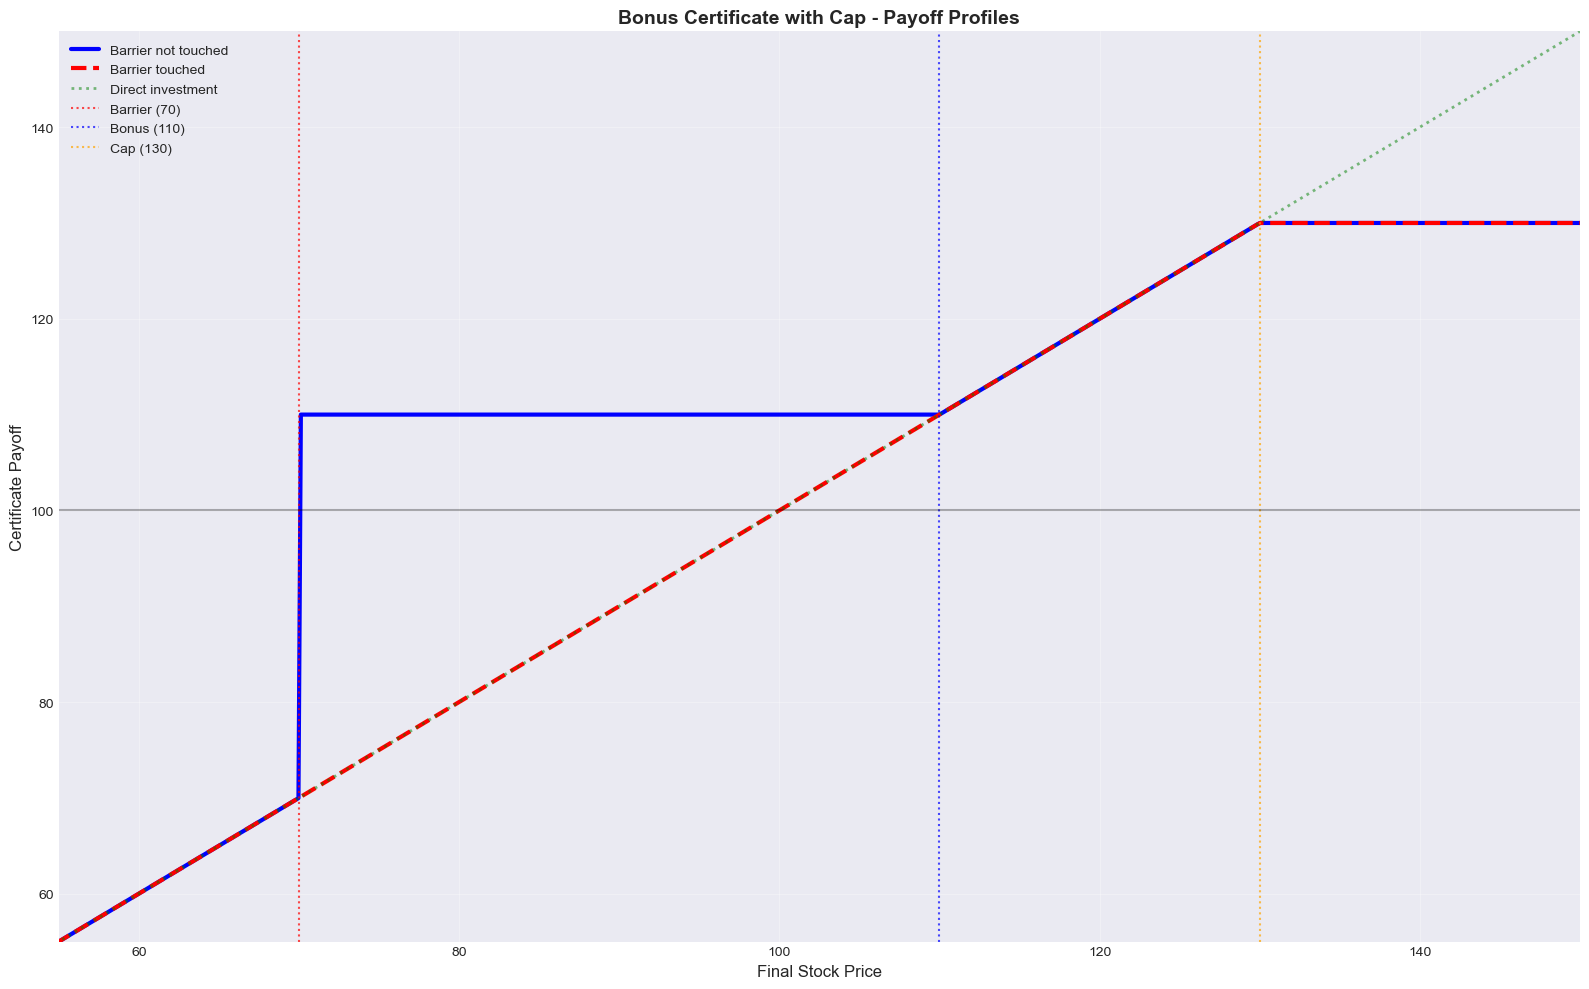

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

P0 = 100
H = 70
B = 110
C = 130

P_T = np.linspace(0, 150, 1000)

payoff_no_touch = np.minimum(np.maximum(P_T, B), C)
payoff_no_touch = np.where(P_T < H, P_T, payoff_no_touch)

payoff_touched = np.minimum(P_T, C)

ax1.plot(P_T, payoff_no_touch, 'b-', linewidth=3, label='Barrier not touched')
ax1.plot(P_T, payoff_touched, 'r--', linewidth=3, label='Barrier touched')
ax1.plot(P_T, P_T, 'g:', linewidth=2, alpha=0.5, label='Direct investment')

ax1.axvline(x=H, color='red', linestyle=':', alpha=0.7, label=f'Barrier ({H})')
ax1.axvline(x=B, color='blue', linestyle=':', alpha=0.7, label=f'Bonus ({B})')
ax1.axvline(x=C, color='orange', linestyle=':', alpha=0.7, label=f'Cap ({C})')
ax1.axhline(y=P0, color='black', linestyle='-', alpha=0.3)

ax1.set_xlabel('Final Stock Price', fontsize=12)
ax1.set_ylabel('Certificate Payoff', fontsize=12)
ax1.set_title('Bonus Certificate with Cap - Payoff Profiles', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(55, 150)
ax1.set_ylim(55, 150)

plt.tight_layout()
plt.show()

### 4. Replication Strategy

### Replication Portfolio for Bonus Certificate with Cap

A **Bonus Certificate with Cap** can be replicated using the following financial instruments:

---

#### 1. **Long Underlying Asset** (1 unit)

- Provides exposure to the full price movement of the underlying asset.

---

#### 2. **Long Down-and-Out Put (DOP)**

- **Strike**: $K = B$ (Bonus Level)  
- **Barrier**: $H$ (Barrier Level)  
- Acts as downside protection as long as the barrier is not breached.  
- If the barrier is touched, the put expires worthless—mirroring the loss of the bonus protection.

---

#### 3. **Short Call Option**

- **Strike**: $K = C$ (Cap Level)  
- Limits upside participation beyond the cap level.

---

### Mathematical Representation

The value of the replication portfolio at time $t$ is:

$$
V(t) = P(t) + \text{DOP}(P(t), B, H, T - t) - \text{Call}(P(t), C, T - t)
$$

Where:

- $V(t)$: Value of the replicating portfolio  
- $P(t)$: Price of the underlying asset at time $t$  
- $\text{DOP}$: Price of the Down-and-Out Put option with strike $B$ and barrier $H$  
- $\text{Call}$: Price of the European Call option with strike $C$

---

### Additional Insight

- The **Down-and-Out Put** ensures a minimum payout (the bonus) only if the barrier is never breached.  
- If the barrier is breached, the DOP becomes worthless, and the investor is exposed to the downside like a direct equity position (with a cap via the short call).  
- The **Short Call** limits any profit above the cap level.  
- This replication strategy mirrors the **path-dependent** nature of the Bonus Certificate while allowing it to be **priced using standard financial instruments**.


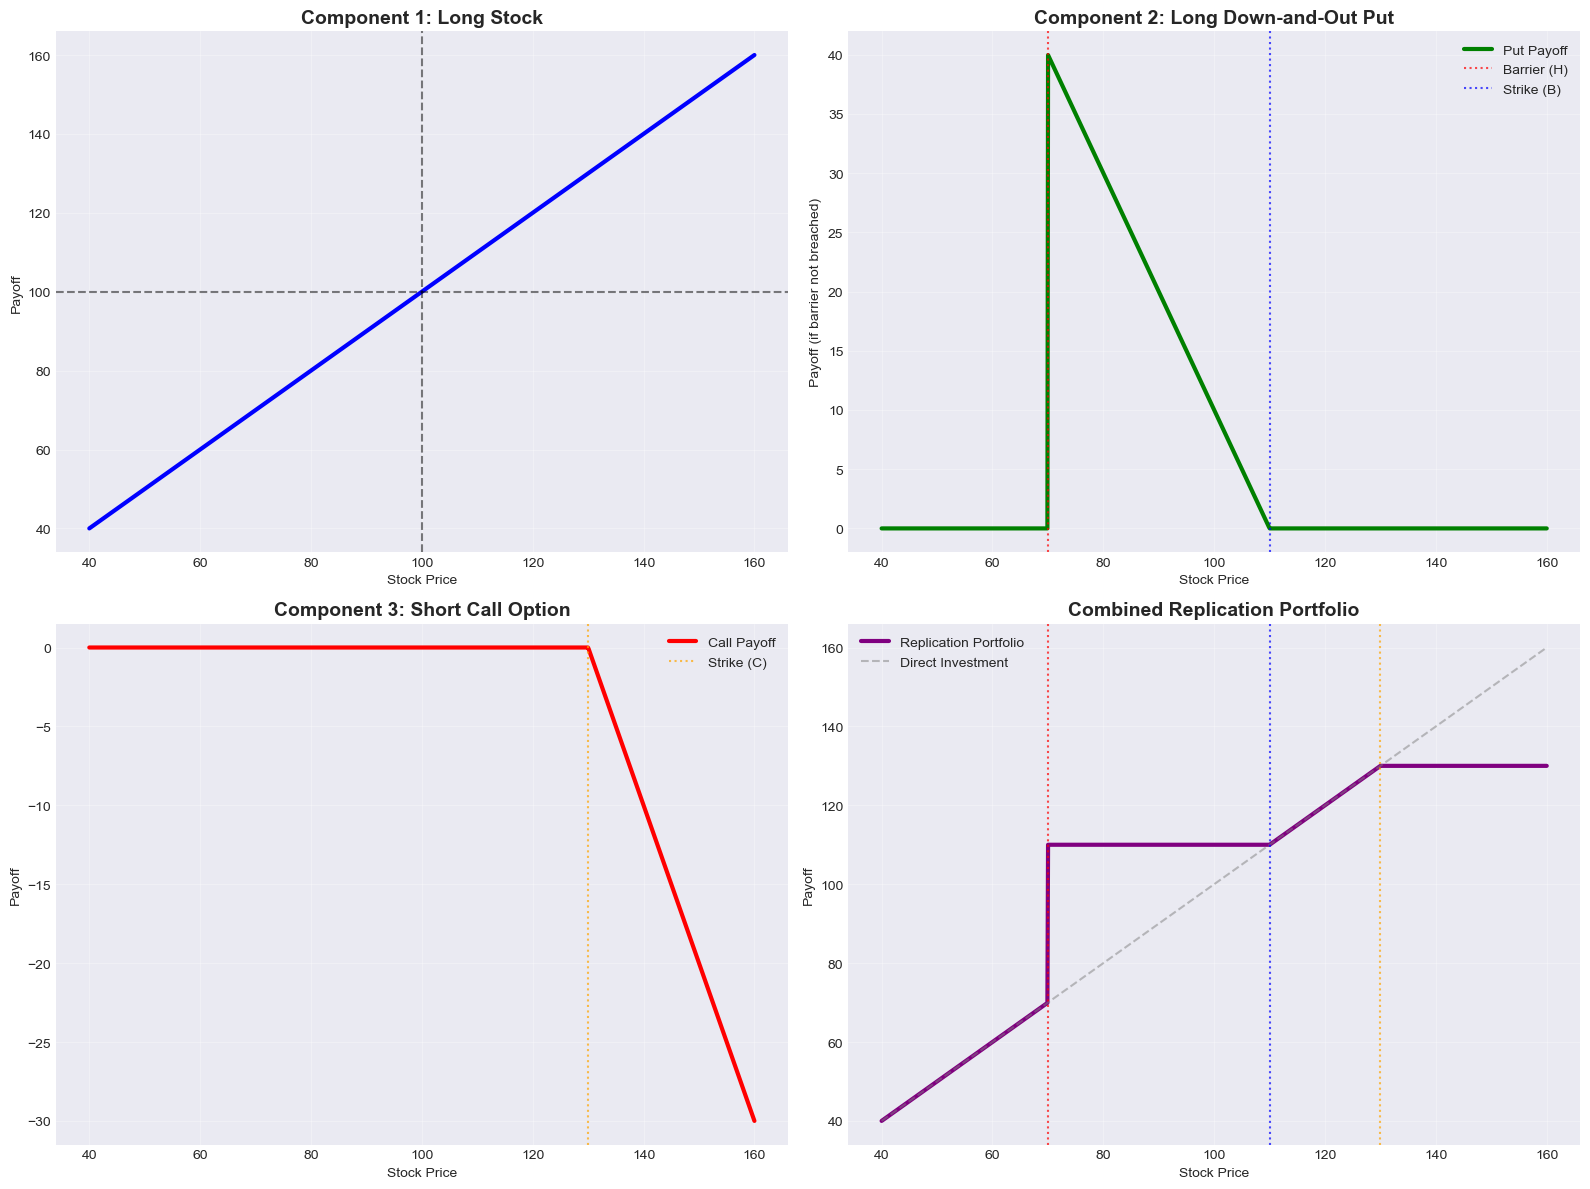

In [8]:
P0 = 100
H = 70
B = 110
C = 130
P_T = np.linspace(40, 160, 1000)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
ax.plot(P_T, P_T, 'b-', linewidth=3)
ax.axhline(y=P0, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=P0, color='black', linestyle='--', alpha=0.5)
ax.set_title('Component 1: Long Stock', fontsize=14, fontweight='bold')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Payoff')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
dop_payoff = np.where(P_T < B, B - P_T, 0)
dop_payoff = np.where(P_T < H, 0, dop_payoff)
ax.plot(P_T, dop_payoff, 'g-', linewidth=3, label='Put Payoff')
ax.axvline(x=H, color='red', linestyle=':', alpha=0.7, label='Barrier (H)')
ax.axvline(x=B, color='blue', linestyle=':', alpha=0.7, label='Strike (B)')
ax.set_title('Component 2: Long Down-and-Out Put', fontsize=14, fontweight='bold')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Payoff (if barrier not breached)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
call_payoff = -np.maximum(P_T - C, 0)
ax.plot(P_T, call_payoff, 'r-', linewidth=3, label='Call Payoff')
ax.axvline(x=C, color='orange', linestyle=':', alpha=0.7, label='Strike (C)')
ax.set_title('Component 3: Short Call Option', fontsize=14, fontweight='bold')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Payoff')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
combined_payoff = P_T + dop_payoff + call_payoff
ax.plot(P_T, combined_payoff, 'purple', linewidth=3, label='Replication Portfolio')
ax.plot(P_T, P_T, 'gray', linestyle='--', alpha=0.5, label='Direct Investment')
ax.axvline(x=H, color='red', linestyle=':', alpha=0.7)
ax.axvline(x=B, color='blue', linestyle=':', alpha=0.7)
ax.axvline(x=C, color='orange', linestyle=':', alpha=0.7)
ax.set_title('Combined Replication Portfolio', fontsize=14, fontweight='bold')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Payoff')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

### 5. Analytical Pricing

In [9]:
def black_scholes_call(P0, K, T, r, sigma):
    def d1(P0, K, r, sigma, T):
        return (np.log(P0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    def d2(P, K, r, sigma, T):
        return d1(P0, K, r, sigma, T) - sigma * np.sqrt(T)

    d1_ = d1(P0, K, r, sigma, T)
    d2_ = d2(P0, K, r, sigma, T)
    
    call_price = P0 * norm.cdf(d1_) - K * np.exp(-r * T) * norm.cdf(d2_)
    
    return call_price

def down_and_out_call(P0, K, H, T, r, sigma):
    if P0 <= H:
        return 0.0
        
    def c1(P0, H, r, sigma, T):
        return (np.log(H**2/(P0*K)) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    def c2(P0, H, r, sigma, T):
        return c1(P0, H, r, sigma, T) - sigma * np.sqrt(T)
    
    doc_lambda = r - 0.5 * sigma**2
    kod = P0 * np.power(H/P0, 2 + 2 * doc_lambda / sigma**2) * norm.cdf(c1(P0, H, r, sigma, T)) - \
                K * np.exp(-r * T) * np.power(H/P0, 2 * doc_lambda / sigma**2) * norm.cdf(c2(P0, H, r, sigma, T))
    
    vanilla_call = black_scholes_call(P0, K, T, r, sigma)
    
    return vanilla_call - kod

def down_and_out_put(P0, K, H, T, r, sigma):
    if P0 <= H:
        return 0.0

    def q1(P0, H, r, sigma, T):
        term1 = norm.cdf((np.log(P0/H) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
        
        term2_coef = np.exp(-2*(r + sigma**2/2)*np.log(P0/H)/sigma**2)
        term2_cdf = norm.cdf((-np.log(P0/H) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
        
        return term1 - term2_coef * term2_cdf

    def q2(P0, H, r, sigma, T):
        term1 = norm.cdf((np.log(P0/H) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
        
        term2_coef = np.exp(-2*(r - sigma**2/2)*np.log(P0/H)/sigma**2)
        term2_cdf = norm.cdf((-np.log(P0/H) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
        
        return term1 - term2_coef * term2_cdf

    Q1 = q1(P0, H, r, sigma, T)
    Q2 = q2(P0, H, r, sigma, T)
    
    doc = down_and_out_call(P0, K, H, T, r, sigma)

    return doc - P0 * Q1 + K * np.exp(-r * T) * Q2

def price_bonus_certificate_analytical(P0, H, B, C, T, r, sigma):
    stock_value = P0
    
    dop_value = down_and_out_put(P0, B, H, T, r, sigma)
    
    call_value = black_scholes_call(P0, C, T, r, sigma)
    
    certificate_value = stock_value + dop_value - call_value
    
    results = {
        'price': certificate_value,
        'components': {
            'stock': stock_value,
            'down_out_put': dop_value,
            'short_call': -call_value
        }
    }
    
    return results

In [10]:
P0 = df['Close'].iloc[-1]
r = 0.02
sigma = bs_params['volatility']
T = 1.0

H = 16
B = 24
C = 28

print(f"Market Parameters:")
print(f"Current Price (P0): {P0:.2f}")
print(f"Risk-free Rate: {r:.2%}")
print(f"Volatility: {sigma:.2%}")
print(f"Time to Maturity: {T} year")

print(f"\nCertificate Parameters:")
print(f"Barrier Level: {H}")
print(f"Bonus Level: {B}")
print(f"Cap Level: {C}")

analytical_price = price_bonus_certificate_analytical(P0, H, B, C, T, r, sigma)

print(f"\nAnalytical Pricing Results:")
print(f"Certificate Price: {analytical_price['price']:.4f}")
print(f"\nComponents:")
for component, value in analytical_price['components'].items():
    print(f"  {component}: {value:.4f}")

Market Parameters:
Current Price (P0): 22.63
Risk-free Rate: 2.00%
Volatility: 21.24%
Time to Maturity: 1.0 year

Certificate Parameters:
Barrier Level: 16
Bonus Level: 24
Cap Level: 28

Analytical Pricing Results:
Certificate Price: 23.7293

Components:
  stock: 22.6300
  down_out_put: 1.6210
  short_call: -0.5217


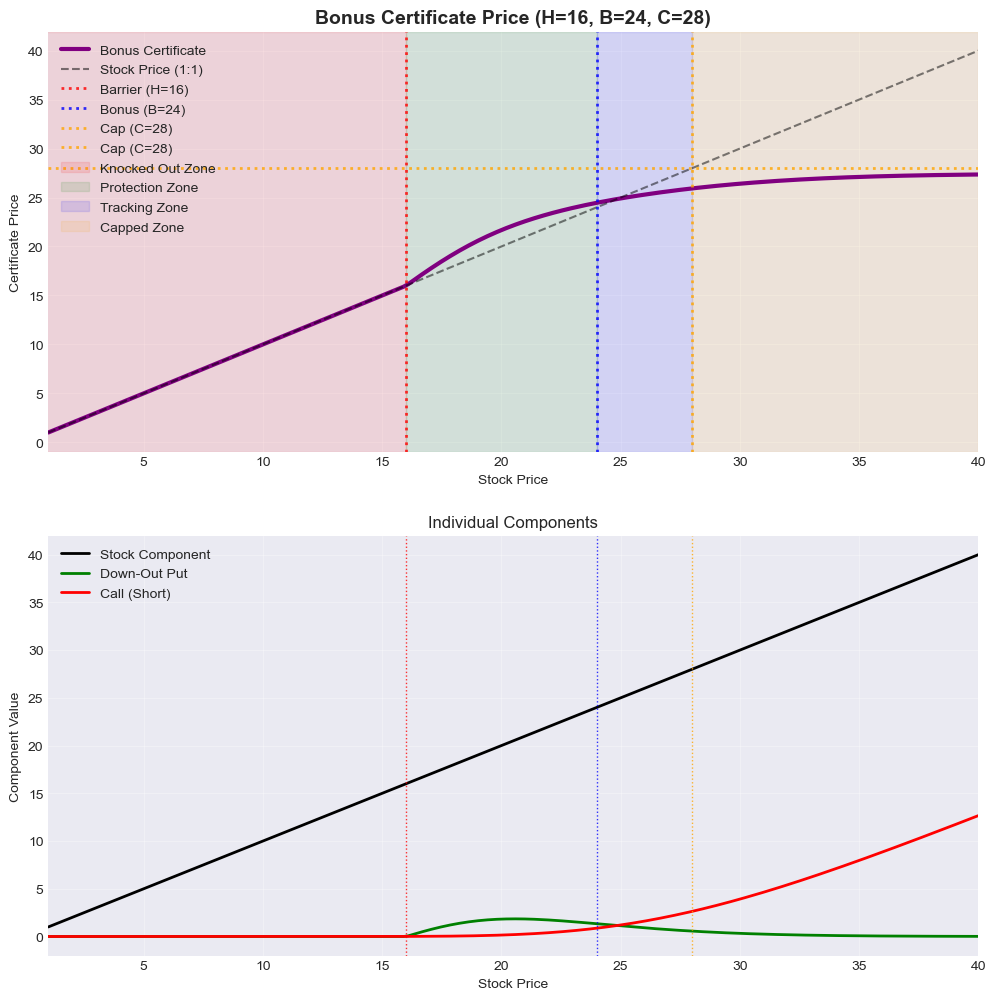

In [11]:
stock_prices = np.linspace(1, 40, 200)

cert_prices = []
stock_values = []
dop_values = []
call_values = []

for S in stock_prices:
    try:
        result = price_bonus_certificate_analytical(S, H, B, C, T, r, sigma)
        cert_prices.append(result['price'])
        stock_values.append(result['components']['stock'])
        dop_values.append(result['components']['down_out_put'])
        call_values.append(-result['components']['short_call'])
    except:
        cert_prices.append(np.nan)
        stock_values.append(S)
        dop_values.append(0)
        call_values.append(0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(stock_prices, cert_prices, 'purple', linewidth=3, label='Bonus Certificate')
ax1.plot(stock_prices, stock_prices, 'k--', alpha=0.5, label='Stock Price (1:1)')

ax1.axvline(x=H, color='red', linestyle=':', alpha=0.8, linewidth=2, label=f'Barrier (H={H})')
ax1.axvline(x=B, color='blue', linestyle=':', alpha=0.8, linewidth=2, label=f'Bonus (B={B})')
ax1.axvline(x=C, color='orange', linestyle=':', alpha=0.8, linewidth=2, label=f'Cap (C={C})')
ax1.axhline(y=C, color='orange', linestyle=':', alpha=0.8, linewidth=2, label=f'Cap (C={C})')

ax1.axvspan(0, H, alpha=0.1, color='red', label='Knocked Out Zone')
ax1.axvspan(H, B, alpha=0.1, color='green', label='Protection Zone')
ax1.axvspan(B, C, alpha=0.1, color='blue', label='Tracking Zone')
ax1.axvspan(C, 40, alpha=0.1, color='orange', label='Capped Zone')

ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Certificate Price')
ax1.set_title('Bonus Certificate Price (H=16, B=24, C=28)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 40)

ax2.plot(stock_prices, stock_values, 'black', linewidth=2, label='Stock Component')
ax2.plot(stock_prices, dop_values, 'green', linewidth=2, label='Down-Out Put')
ax2.plot(stock_prices, call_values, 'red', linewidth=2, label='Call (Short)')

ax2.axvline(x=H, color='red', linestyle=':', alpha=0.8, linewidth=1)
ax2.axvline(x=B, color='blue', linestyle=':', alpha=0.8, linewidth=1)
ax2.axvline(x=C, color='orange', linestyle=':', alpha=0.8, linewidth=1)

ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Component Value')
ax2.set_title('Individual Components', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, 40);

### 6. Monte Carlo Simulation

In [12]:
@jit(nopython=True, parallel=True)
def simulate_paths_with_tracking(P0, H, B, C, T, r, sigma, n_simulations, n_steps):
    dt = T / n_steps
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    payoffs = np.zeros(n_simulations)
    barrier_breached = np.zeros(n_simulations, dtype=np.bool_)
    final_prices = np.zeros(n_simulations)
    
    for i in prange(n_simulations):
        P = P0
        barrier_hit = False
        
        for step in range(n_steps):
            z = np.random.standard_normal()
            P = P * np.exp(drift + diffusion * z)
            
            if P <= H and not barrier_hit:
                barrier_hit = True
        
        barrier_breached[i] = barrier_hit
        final_prices[i] = P
        
        if barrier_hit:
            payoffs[i] = min(P, C)
        else:
            payoffs[i] = min(max(P, B), C)
    
    return payoffs, barrier_breached, final_prices

def monte_carlo_bonus_certificate(P0, H, B, C, T, r, sigma, n_simulations=100000, n_steps=252):
    payoffs, barrier_breached, final_prices = simulate_paths_with_tracking(
        P0, H, B, C, T, r, sigma, n_simulations, n_steps
    )
    
    discounted_payoffs = payoffs * np.exp(-r * T)
    
    price = np.mean(discounted_payoffs)
    std_error = np.std(discounted_payoffs) / np.sqrt(n_simulations)
    conf_interval = (price - 1.96 * std_error, price + 1.96 * std_error)
    
    prob_barrier_breach = np.mean(barrier_breached)
    
    no_breach_mask = ~barrier_breached
    breach_mask = barrier_breached
    
    avg_payoff_no_breach = np.mean(payoffs[no_breach_mask]) if np.any(no_breach_mask) else 0
    avg_payoff_breach = np.mean(payoffs[breach_mask]) if np.any(breach_mask) else 0
    
    results = {
        'price': price,
        'std_error': std_error,
        'confidence_interval_95': conf_interval,
        'statistics': {
            'prob_barrier_breach': prob_barrier_breach,
            'avg_payoff_no_breach': avg_payoff_no_breach,
            'avg_payoff_breach': avg_payoff_breach,
            'paths_simulated': n_simulations
        }
    }
    
    return results

def monte_carlo_bonus_certificate_with_plots(P0, H, B, C, T, r, sigma, n_simulations=100000, n_steps=252, 
                                           show_plots=True, n_plot_paths=100):
    results = monte_carlo_bonus_certificate(P0, H, B, C, T, r, sigma, n_simulations, n_steps)
    
    if show_plots:
        print(f"Generating plots with {n_plot_paths} sample paths...")
        
        dt = T / n_steps
        Z_plot = np.random.standard_normal((n_plot_paths, n_steps))
        
        paths = np.zeros((n_plot_paths, n_steps + 1))
        paths[:, 0] = P0
        barrier_breached_plot = np.zeros(n_plot_paths, dtype=bool)
        
        for t in range(1, n_steps + 1):
            paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + 
                                                  sigma * np.sqrt(dt) * Z_plot[:, t-1])
            barrier_breached_plot |= (paths[:, t] <= H)
        
        S_T_plot = paths[:, -1]
        payoffs_plot = np.zeros(n_plot_paths)
        
        no_breach_mask = ~barrier_breached_plot
        breach_mask = barrier_breached_plot
        
        payoffs_plot[no_breach_mask] = np.minimum(np.maximum(S_T_plot[no_breach_mask], B), C)
        payoffs_plot[breach_mask] = np.minimum(S_T_plot[breach_mask], C)
        
        discounted_payoffs_plot = payoffs_plot * np.exp(-r * T)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        time_grid = np.linspace(0, T, n_steps + 1)
        
        for i in range(min(n_plot_paths, 100)):
            color = 'red' if barrier_breached_plot[i] else 'blue'
            alpha = 0.1 if barrier_breached_plot[i] else 0.2
            ax1.plot(time_grid, paths[i, :], color=color, alpha=alpha, linewidth=0.5)
        
        ax1.axhline(y=H, color='red', linestyle='--', linewidth=2, label=f'Barrier ({H})')
        ax1.axhline(y=B, color='green', linestyle='--', linewidth=2, label=f'Bonus ({B})')
        ax1.axhline(y=C, color='orange', linestyle='--', linewidth=2, label=f'Cap ({C})')
        ax1.set_xlabel('Time (years)', fontsize=12)
        ax1.set_ylabel('Stock Price', fontsize=12)
        ax1.set_title(f'Monte Carlo Simulation Paths (showing {min(n_plot_paths, 100)} paths)', 
                      fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        payoffs_hist, _, _ = simulate_paths_with_tracking(P0, H, B, C, T, r, sigma, 
                                                         min(10000, n_simulations), n_steps)
        discounted_hist = payoffs_hist * np.exp(-r * T)
        
        ax2.hist(discounted_hist, bins=50, density=True, alpha=0.7, 
                 color='skyblue', edgecolor='black')
        ax2.axvline(x=results['price'], color='red', linestyle='--', linewidth=2, 
                    label=f"Mean: {results['price']:.2f}")
        ci = results['confidence_interval_95']
        ax2.axvline(x=ci[0], color='orange', linestyle=':', linewidth=2,
                    label=f'95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]')
        ax2.axvline(x=ci[1], color='orange', linestyle=':', linewidth=2)
        ax2.set_xlabel('Discounted Payoff', fontsize=12)
        ax2.set_ylabel('Density', fontsize=12)
        ax2.set_title('Distribution of Discounted Payoffs', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results

Generating plots with 100 sample paths...


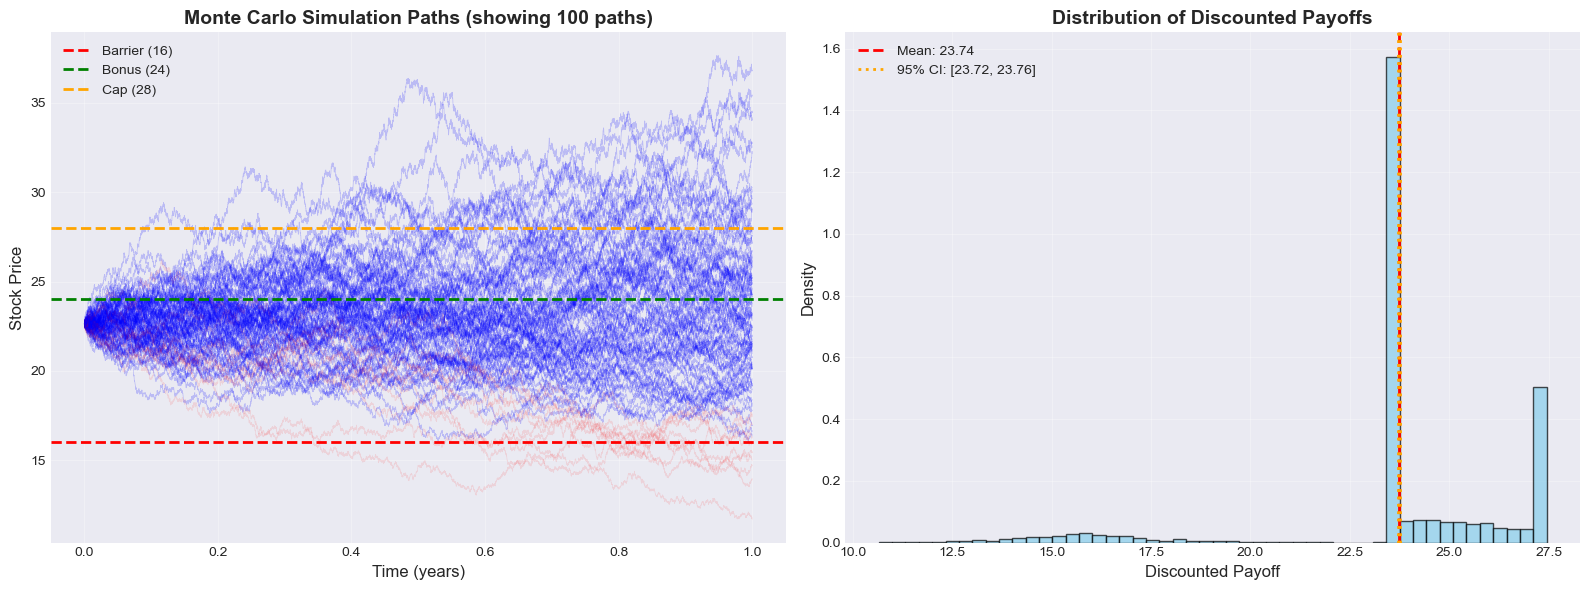


Monte Carlo Results:
Price Estimate: 23.7418
Standard Error: 0.009980
95% Confidence Interval: [23.7222, 23.7613]

Simulation Statistics:
  prob_barrier_breach: 10.37%
  avg_payoff_no_breach: 25.16
  avg_payoff_breach: 16.09
  paths_simulated: 100000.00

Pricing Difference (MC vs Analytical): 0.0125


In [13]:
mc_results = monte_carlo_bonus_certificate_with_plots(P0, H, B, C, T, r, sigma, n_simulations=100000, n_steps=10000, show_plots=True)

print(f"\nMonte Carlo Results:")
print(f"Price Estimate: {mc_results['price']:.4f}")
print(f"Standard Error: {mc_results['std_error']:.6f}")
print(f"95% Confidence Interval: [{mc_results['confidence_interval_95'][0]:.4f}, "
        f"{mc_results['confidence_interval_95'][1]:.4f}]")
print(f"\nSimulation Statistics:")
for stat, value in mc_results['statistics'].items():
    if 'prob' in stat:
        print(f"  {stat}: {value:.2%}")
    else:
        print(f"  {stat}: {value:.2f}")

print(f"\nPricing Difference (MC vs Analytical): "
        f"{abs(mc_results['price'] - analytical_price['price']):.4f}")

### 7. Risk Analysis

In [14]:
def simulate_physical_measure(P0, mu, sigma, T, n_simulations=10000, n_steps=252):
    H = 16
    B = 24
    C = 28
    
    dt = T / n_steps
    
    Z = np.random.standard_normal((n_simulations, n_steps))
    paths = np.zeros((n_simulations, n_steps + 1))
    paths[:, 0] = P0
    
    barrier_breached = np.zeros(n_simulations, dtype=bool)
    
    for t in range(1, n_steps + 1):
        paths[:, t] = paths[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + 
                                              sigma * np.sqrt(dt) * Z[:, t-1])
        barrier_breached |= (paths[:, t] <= H)
    
    P_T = paths[:, -1]
    
    cert_payoffs = np.zeros(n_simulations)
    no_breach = ~barrier_breached
    cert_payoffs[no_breach] = np.minimum(np.maximum(P_T[no_breach], B), C)
    cert_payoffs[barrier_breached] = np.minimum(P_T[barrier_breached], C)
    
    stock_returns = P_T / P0
    cert_returns = cert_payoffs / P0
    
    def calculate_risk_metrics(returns):
        log_returns = np.log(returns)
        
        metrics = {
            'mean': np.mean(returns),
            'std': np.std(returns),
            'log_mean': np.mean(log_returns),
            'log_std': np.std(log_returns),
            'skewness': stats.skew(log_returns),
            'kurtosis': stats.kurtosis(log_returns),
            'var_5': np.percentile(returns, 5),
            'cvar_5': np.mean(returns[returns <= np.percentile(returns, 5)]),
            'max_return': np.max(returns),
            'min_return': np.min(returns),
            'sharpe_ratio': (np.mean(returns) - 1) / np.std(returns) if np.std(returns) > 0 else 0,
            'prob_loss': np.mean(returns < 1),
            'prob_gain_10pct': np.mean(returns > 1.1),
            'prob_max_return': np.mean(returns >= C/P0)
        }
        
        return metrics
    
    stock_metrics = calculate_risk_metrics(stock_returns)
    cert_metrics = calculate_risk_metrics(cert_returns)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    ax = axes[0, 0]
    bins = np.linspace(min(stock_returns.min(), cert_returns.min()), 
                      max(stock_returns.max(), cert_returns.max()), 50)
    ax.hist(stock_returns, bins=bins, alpha=0.5, label='Stock', density=True, color='blue')
    ax.hist(cert_returns, bins=bins, alpha=0.5, label='Certificate', density=True, color='red')
    ax.axvline(x=1, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Return Multiple', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Return Distributions (Physical Measure)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    stats.probplot(cert_returns - stock_returns, dist="norm", plot=ax)
    ax.set_title('Q-Q Plot: Certificate vs Stock Returns', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 0]
    percentiles = np.linspace(5, 95, 19)
    stock_percentiles = [np.percentile(stock_returns, p) for p in percentiles]
    cert_percentiles = [np.percentile(cert_returns, p) for p in percentiles]
    
    ax.scatter(stock_percentiles, cert_percentiles, s=50, alpha=0.7)
    ax.plot([0.5, 1.5], [0.5, 1.5], 'k--', alpha=0.5, label='45° line')
    
    for p, sp, cp in zip(percentiles, stock_percentiles, cert_percentiles):
        if p in [5, 25, 50, 75, 95]:
            ax.annotate(f'{p}%', (sp, cp), xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel('Stock Return', fontsize=12)
    ax.set_ylabel('Certificate Return', fontsize=12)
    ax.set_title('Return Percentiles Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax = axes[1, 1]
    metrics_names = ['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'VaR 5%', 'CVaR 5%']
    stock_values = [stock_metrics['mean'], stock_metrics['std'], 
                   stock_metrics['skewness'], stock_metrics['kurtosis'],
                   stock_metrics['var_5'], stock_metrics['cvar_5']]
    cert_values = [cert_metrics['mean'], cert_metrics['std'],
                  cert_metrics['skewness'], cert_metrics['kurtosis'],
                  cert_metrics['var_5'], cert_metrics['cvar_5']]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    ax.bar(x - width/2, stock_values, width, label='Stock', alpha=0.7)
    ax.bar(x + width/2, cert_values, width, label='Certificate', alpha=0.7)
    
    ax.set_xlabel('Risk Metric', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title('Risk Metrics Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("RISK METRICS COMPARISON (Physical Measure)")
    print("="*60)
    print(f"{'Metric':<25} {'Stock':>12} {'Certificate':>12} {'Difference':>12}")
    print("-"*60)
    
    for metric in ['mean', 'std', 'skewness', 'kurtosis', 'var_5', 'cvar_5', 
                   'sharpe_ratio', 'prob_loss', 'prob_gain_10pct']:
        stock_val = stock_metrics[metric]
        cert_val = cert_metrics[metric]
        diff = cert_val - stock_val
        print(f"{metric:<25} {stock_val:>12.4f} {cert_val:>12.4f} {diff:>12.4f}")
    
    print("\nBarrier Breach Probability:", f"{np.mean(barrier_breached):.2%}")
    print("Certificate at Max Payout:", f"{cert_metrics['prob_max_return']:.2%}")
    
    return {
        'stock_returns': stock_returns,
        'cert_returns': cert_returns,
        'stock_metrics': stock_metrics,
        'cert_metrics': cert_metrics,
        'barrier_breach_prob': np.mean(barrier_breached),
        'paths': paths
    }

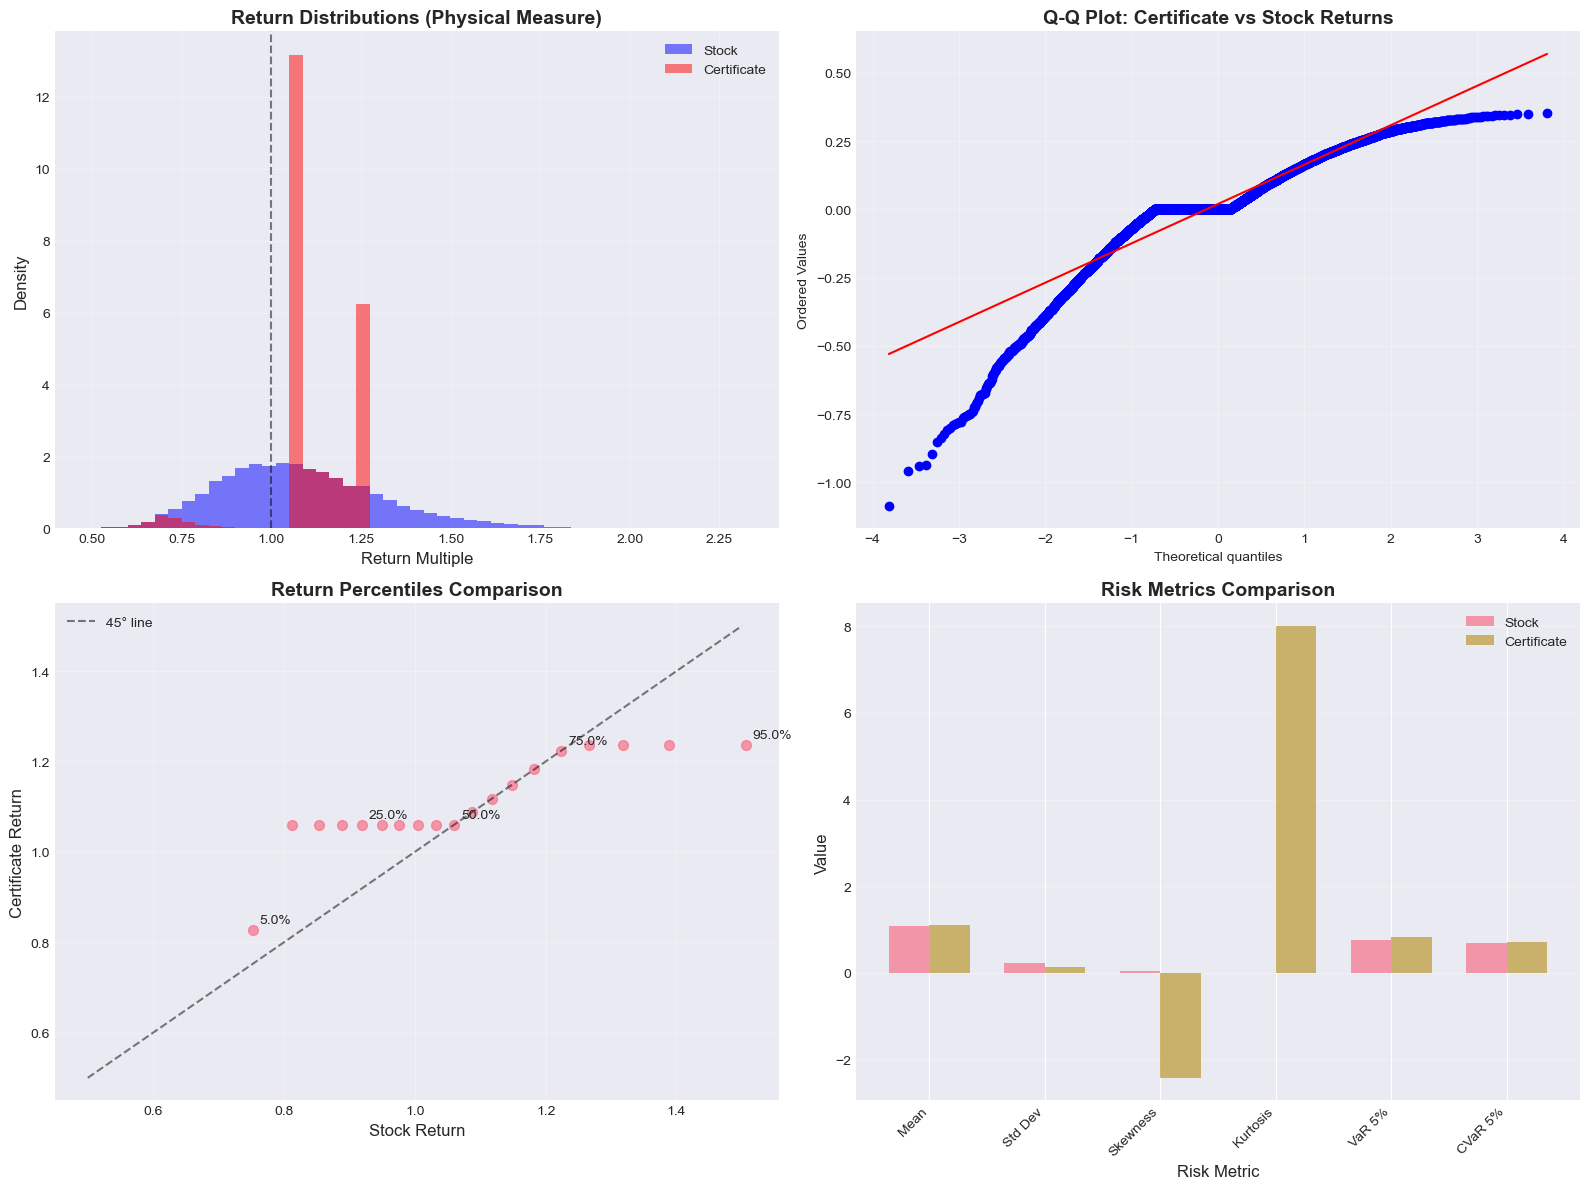


RISK METRICS COMPARISON (Physical Measure)
Metric                           Stock  Certificate   Difference
------------------------------------------------------------
mean                            1.0846       1.1043       0.0197
std                             0.2320       0.1212      -0.1108
skewness                        0.0299      -2.4304      -2.4602
kurtosis                       -0.0006       8.0122       8.0128
var_5                           0.7519       0.8281       0.0762
cvar_5                          0.6908       0.6996       0.0088
sharpe_ratio                    0.3648       0.8605       0.4957
prob_loss                       0.3916       0.0558      -0.3358
prob_gain_10pct                 0.4299       0.4299       0.0000

Barrier Breach Probability: 5.63%
Certificate at Max Payout: 23.38%

Key Observations:
1. The certificate reduces volatility by 47.7%
2. Downside protection active in 94.4% of scenarios
3. Maximum return capped in 23.4% of scenarios
4. Certific

In [15]:
physical_results = simulate_physical_measure(P0, bs_params['drift'], sigma, T)

print("\nKey Observations:")
print(f"1. The certificate reduces volatility by {(1 - physical_results['cert_metrics']['std']/physical_results['stock_metrics']['std']):.1%}")
print(f"2. Downside protection active in {(1 - physical_results['barrier_breach_prob']):.1%} of scenarios")
print(f"3. Maximum return capped in {physical_results['cert_metrics']['prob_max_return']:.1%} of scenarios")
print(f"4. Certificate outperforms in {np.mean(physical_results['cert_returns'] > physical_results['stock_returns']):.1%} of scenarios")